# Exploration: Embeddings

## Lesson 4 Homework Assignment

MovieLens dataset: https://grouplens.org/datasets/movielens/

In [1]:
import os
current_dir = os.getcwd()

LESSON_HOME_DIR = current_dir + '/'
DATA_HOME_DIR = LESSON_HOME_DIR + 'data/'

#DATASET_DIR = DATA_HOME_DIR + 'ml-20m/'
DATASET_DIR = DATA_HOME_DIR + 'ml-small/'
MODEL_DIR = DATASET_DIR + 'models/'

In [2]:
if not os.path.exists(DATASET_DIR):
    %cd $DATA_HOME_DIR
    #!wget http://files.grouplens.org/datasets/movielens/ml-20m.zip
    #!unzip ml-20m.zip
    !wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
    !unzip ml-latest-small.zip && mv ml-latest-small ml-small

In [3]:
if not os.path.exists(MODEL_DIR): os.mkdir(MODEL_DIR)

## Data Setup

In [4]:
import pandas as pd
import numpy as np

In [5]:
ratings = pd.read_csv(DATASET_DIR+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
len(ratings)

100004

Movie names for a more user-friendly display

In [7]:
movie_names = pd.read_csv(DATASET_DIR+'movies.csv').set_index('movieId')['title'].to_dict()

In [8]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

Update movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())

user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

n_users, n_movies

(671, 9066)

Set the number of latent factors in each embedding.

In [12]:
n_factors = 50

Slick way to randomly split data into training and validation.

In [13]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

In [14]:
len(trn), len(val)

(80300, 19704)

In [15]:
batch_size=64

## Dot Product Model

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [16]:
from keras.layers import Input, Embedding, merge
from keras.layers.core import Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [17]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [18]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [19]:
user_in, user_embed = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, movie_embed = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [20]:
x = merge([user_embed, movie_embed], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [22]:
model.optimizer.lr.get_value().item()

0.0010000000474974513

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/1
80300/80300 [==============================] - 9s - loss: 10.1263 - val_loss: 3.9459


Let's track predictions as we train.

In [46]:
def get_prediction(m, user_id=3, movie_id=6):
    return np.squeeze(m.predict([np.array([user_id]), np.array([movie_id])])).item()

In [24]:
predictions = []

In [25]:
predictions.append(get_prediction(model))
predictions

[2.674907922744751]

In [26]:
model.optimizer.lr=0.01

In [27]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/3
80300/80300 [==============================] - 9s - loss: 3.1633 - val_loss: 1.9999
Epoch 2/3
80300/80300 [==============================] - 9s - loss: 2.3909 - val_loss: 1.6289
Epoch 3/3
80300/80300 [==============================] - 9s - loss: 2.2140 - val_loss: 1.5055


In [28]:
predictions.append(get_prediction(model))
predictions

[2.674907922744751, 4.7747297286987305]

In [29]:
model.optimizer.lr=0.001

In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/6
80300/80300 [==============================] - 9s - loss: 2.1458 - val_loss: 1.4577
Epoch 2/6
80300/80300 [==============================] - 9s - loss: 2.1092 - val_loss: 1.4491
Epoch 3/6
80300/80300 [==============================] - 9s - loss: 2.0849 - val_loss: 1.4375
Epoch 4/6
80300/80300 [==============================] - 9s - loss: 2.0669 - val_loss: 1.4350
Epoch 5/6
80300/80300 [==============================] - 9s - loss: 2.0466 - val_loss: 1.4405
Epoch 6/6
80300/80300 [==============================] - 9s - loss: 2.0271 - val_loss: 1.4394


In [31]:
predictions.append(get_prediction(model))
predictions

[2.674907922744751, 4.7747297286987305, 4.9882402420043945]

According to the course, the best benchmarks for `loss` are a bit over `0.9`, so this model doesn't seem to be working that well...

### Adding Bias

Bias represents how positive or negative each user is, and how good each movie is.

In [32]:
user_in, user_embed = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, movie_embed = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [33]:
user_bias = create_bias(user_in, n_users)
movie_bias = create_bias(movie_in, n_movies)

In [34]:
x = merge([user_embed, movie_embed], mode='dot')
x = Flatten()(x)
x = merge([x, user_bias], mode='sum')
x = merge([x, movie_bias], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

In [36]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/1
80300/80300 [==============================] - 7s - loss: 8.8772 - val_loss: 3.1143


In [37]:
predictions = []

In [38]:
predictions.append(get_prediction(model))
predictions

[3.4523675441741943]

In [39]:
model.optimizer.lr=0.01

In [40]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/3
80300/80300 [==============================] - 7s - loss: 2.5847 - val_loss: 1.6254
Epoch 2/3
80300/80300 [==============================] - 7s - loss: 2.0013 - val_loss: 1.3378
Epoch 3/3
80300/80300 [==============================] - 7s - loss: 1.8468 - val_loss: 1.2329


In [41]:
predictions.append(get_prediction(model))
predictions

[3.4523675441741943, 4.308851718902588]

In [42]:
model.optimizer.lr=0.001

In [43]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/6
80300/80300 [==============================] - 7s - loss: 1.7555 - val_loss: 1.1709
Epoch 2/6
80300/80300 [==============================] - 7s - loss: 1.6759 - val_loss: 1.1355
Epoch 3/6
80300/80300 [==============================] - 7s - loss: 1.5994 - val_loss: 1.1018
Epoch 4/6
80300/80300 [==============================] - 7s - loss: 1.5261 - val_loss: 1.0769
Epoch 5/6
80300/80300 [==============================] - 7s - loss: 1.4523 - val_loss: 1.0510
Epoch 6/6
80300/80300 [==============================] - 7s - loss: 1.3838 - val_loss: 1.0181


In [44]:
predictions.append(get_prediction(model))
predictions

[3.4523675441741943, 4.308851718902588, 4.759426593780518]

Loss is significally lower after equivalent epochs cycle from before. So let's keep training!

In [45]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/10
80300/80300 [==============================] - 7s - loss: 1.3167 - val_loss: 0.9986
Epoch 2/10
80300/80300 [==============================] - 7s - loss: 1.2526 - val_loss: 0.9739
Epoch 3/10
80300/80300 [==============================] - 7s - loss: 1.1907 - val_loss: 0.9537
Epoch 4/10
80300/80300 [==============================] - 7s - loss: 1.1326 - val_loss: 0.9378
Epoch 5/10
80300/80300 [==============================] - 7s - loss: 1.0766 - val_loss: 0.9151
Epoch 6/10
80300/80300 [==============================] - 7s - loss: 1.0235 - val_loss: 0.8987
Epoch 7/10
80300/80300 [==============================] - 7s - loss: 0.9734 - val_loss: 0.8827
Epoch 8/10
80300/80300 [==============================] - 7s - loss: 0.9267 - val_loss: 0.8692
Epoch 9/10
80300/80300 [==============================] - 7s - loss: 0.8828 - val_loss: 0.8537
Epoch 10/10
80300/80300 [==============================] - 7s - loss: 0.8421 - val_loss: 0.8427

In [47]:
predictions.append(get_prediction(model))
predictions

[3.4523675441741943, 4.308851718902588, 4.759426593780518, 5.333425045013428]

In [48]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/5
80300/80300 [==============================] - 7s - loss: 0.8046 - val_loss: 0.8320
Epoch 2/5
80300/80300 [==============================] - 7s - loss: 0.7702 - val_loss: 0.8236
Epoch 3/5
80300/80300 [==============================] - 7s - loss: 0.7387 - val_loss: 0.8164
Epoch 4/5
80300/80300 [==============================] - 7s - loss: 0.7100 - val_loss: 0.8092
Epoch 5/5
80300/80300 [==============================] - 7s - loss: 0.6844 - val_loss: 0.8029


In [49]:
predictions.append(get_prediction(model))
predictions

[3.4523675441741943,
 4.308851718902588,
 4.759426593780518,
 5.333425045013428,
 4.959123611450195]

Loss is now quite a bit better than the `0.9` benchmark.

Interesting that the rating prediction went above `5` after a certain number of epochs.

In [50]:
if not os.path.exists(MODEL_DIR + 'bias.h5'):
    model.save_weights(MODEL_DIR + 'bias.h5')
model.load_weights(MODEL_DIR + 'bias.h5')

## Deep Neural Network Model

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [51]:
from keras.layers.core import Dense, Dropout

In [52]:
user_in, user_embed = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, movie_embed = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [53]:
x = merge([user_embed, movie_embed], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [54]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

Run the same initial epoch cycle again...

In [55]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/1
80300/80300 [==============================] - 9s - loss: 2.5007 - val_loss: 0.9397


In [56]:
predictions = []

In [57]:
predictions.append(get_prediction(nn))
predictions

[4.0861711502075195]

In [58]:
nn.optimizer.lr=0.01

In [59]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/3
80300/80300 [==============================] - 9s - loss: 1.4957 - val_loss: 0.8532
Epoch 2/3
80300/80300 [==============================] - 9s - loss: 1.2459 - val_loss: 0.8242
Epoch 3/3
80300/80300 [==============================] - 9s - loss: 1.0474 - val_loss: 0.8049


In [60]:
predictions.append(get_prediction(nn))
predictions

[4.0861711502075195, 4.420107841491699]

In [61]:
nn.optimizer.lr=0.001

In [62]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80300 samples, validate on 19704 samples
Epoch 1/6
80300/80300 [==============================] - 9s - loss: 0.9097 - val_loss: 0.7974
Epoch 2/6
80300/80300 [==============================] - 9s - loss: 0.8452 - val_loss: 0.7806
Epoch 3/6
80300/80300 [==============================] - 9s - loss: 0.8162 - val_loss: 0.7801
Epoch 4/6
80300/80300 [==============================] - 9s - loss: 0.8087 - val_loss: 0.7797
Epoch 5/6
80300/80300 [==============================] - 9s - loss: 0.8018 - val_loss: 0.7777
Epoch 6/6
80300/80300 [==============================] - 9s - loss: 0.8012 - val_loss: 0.7779


In [63]:
predictions.append(get_prediction(nn))
predictions

[4.0861711502075195, 4.420107841491699, 4.6849822998046875]

Again, respectable loss. Also note that we arrive at an 4+ rating prediction after the very first iteration (took more epochs with the dot product models).

## Latent Factor Analysis

...of the top 2000 most popular movies.

In [64]:
counts = ratings.groupby('movieId')['rating'].count()
topMovies = counts.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [65]:
# arbitrary indices from counting movies with the most ratings
topMovies[:10]

array([ 57,  49,  99,  92, 143,  72, 402, 417,  79,  89])

In [66]:
# MovieLens indices
[movies[topMovies[i]] for i in range(10)]

[356, 296, 318, 593, 260, 480, 2571, 1, 527, 589]

In [67]:
# Movie names
[movie_names[movies[topMovies[i]]] for i in range(10)]

['Forrest Gump (1994)',
 'Pulp Fiction (1994)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Jurassic Park (1993)',
 'Matrix, The (1999)',
 'Toy Story (1995)',
 "Schindler's List (1993)",
 'Terminator 2: Judgment Day (1991)']

We'll look at the movie embeddings. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie's embedding (an array of 50 latent factors).

In [68]:
get_movie_emb = Model(movie_in, movie_embed)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 latent factors, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to perform dimensionality reduction.

### Eigenvalues and Explained Variance

We're going to use the _eigenvalues_ of the movie embeddings matrix to determine how much _explained variance_ to attribute to each principal component, 1 to 50.

In [100]:
cor_mat = np.corrcoef(movie_emb.T)

In [101]:
eig_vals, _ = np.linalg.eig(cor_mat)

In [109]:
eig_vals = [np.abs(eig_vals[i]) for i in range(len(eig_vals))]
eig_vals.sort()
eig_vals.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_vals[:10]:
    print(i)
print('...')

Eigenvalues in descending order:
15.9814474304
6.37987499307
1.54675343944
1.35259911476
1.2248882552
1.13403056403
1.09888581263
1.01084556394
0.927359428709
0.841517956203
...


In [107]:
p_range = 10

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print('(component n, % explained variance, total % explained variance)')
zip(range(1, p_range+1), var_exp[:p_range], cum_var_exp[:p_range])

(component n, % explained variance, total % explained variance)


[(1, 31.962894860704939, 31.962894860704939),
 (2, 12.75974998614244, 44.722644846847381),
 (3, 3.0935068788797855, 47.816151725727167),
 (4, 2.7051982295123862, 50.52134995523955),
 (5, 2.4497765103944862, 52.971126465634036),
 (6, 2.2680611280528162, 55.23918759368685),
 (7, 2.1977716252537487, 57.436959218940601),
 (8, 2.0216911278803593, 59.45865034682096),
 (9, 1.8547188574172511, 61.313369204238214),
 (10, 1.6830359124058318, 62.996405116644048)]

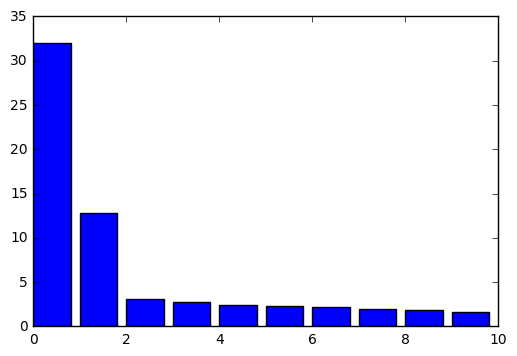

In [106]:
import matplotlib.pyplot as plt

x = range(p_range)
plt.bar(x, var_exp[:p_range])
plt.show()

It looks like the first 2 components, which explain 44.7% of the variance, also represent the biggest chunks of data. So we will perform PCA on the first 2 components.

### PCA

In [113]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [114]:
pca = PCA(n_components=2)
movie_pca = pca.fit(movie_emb.T).components_

In [115]:
fac1 = movie_pca[0]
movie_comp1 = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

In [117]:
sorted(movie_comp1, key=itemgetter(0))[:10]

[(-0.073133297, 'Godfather, The (1972)'),
 (-0.058403701, 'Shawshank Redemption, The (1994)'),
 (-0.05740932, 'Princess Bride, The (1987)'),
 (-0.056297582, 'Godfather: Part II, The (1974)'),
 (-0.056040868, 'Usual Suspects, The (1995)'),
 (-0.055370882, "Schindler's List (1993)"),
 (-0.054995812, 'Maltese Falcon, The (1941)'),
 (-0.053519577, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (-0.053115312, 'Pulp Fiction (1994)'),
 (-0.051533874, 'Silence of the Lambs, The (1991)')]

In [116]:
sorted(movie_comp1, key=itemgetter(0), reverse=True)[:10]

[(0.060862768, 'Police Academy 3: Back in Training (1986)'),
 (0.057792626, 'Island of Dr. Moreau, The (1996)'),
 (0.056795582, 'Battlefield Earth (2000)'),
 (0.055127073, 'Bio-Dome (1996)'),
 (0.053010106, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.050806917,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (0.050182238, 'Showgirls (1995)'),
 (0.049462657, 'Congo (1995)'),
 (0.049122024, 'Tank Girl (1995)'),
 (0.049066816, 'Police Academy 5: Assignment: Miami Beach (1988)')]

In [118]:
fac2 = movie_pca[1]
movie_comp2 = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

In [119]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.05548089, 'Police Academy 6: City Under Siege (1989)'),
 (-0.054965112, 'Striptease (1996)'),
 (-0.05384833, '13 Going on 30 (2004)'),
 (-0.051035933, 'Battlefield Earth (2000)'),
 (-0.050773095, 'Avengers, The (1998)'),
 (-0.050502747, 'Goofy Movie, A (1995)'),
 (-0.050188724, "Pan's Labyrinth (Laberinto del fauno, El) (2006)"),
 (-0.050007805, 'How to Lose a Guy in 10 Days (2003)'),
 (-0.048598133, 'African Queen, The (1951)'),
 (-0.048496999, 'Legally Blonde (2001)')]

In [120]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.085584946, 'Doors, The (1991)'),
 (0.078515723, 'Lawnmower Man, The (1992)'),
 (0.075442813, 'Pacific Rim (2013)'),
 (0.071781643, 'Natural Born Killers (1994)'),
 (0.067862138, 'Arachnophobia (1990)'),
 (0.066941552, 'From Dusk Till Dawn (1996)'),
 (0.064387925, 'Patriot Games (1992)'),
 (0.061787196, 'Pitch Black (2000)'),
 (0.061753605, 'Virgin Suicides, The (1999)'),
 (0.061439462, 'Whole Nine Yards, The (2000)')]